**AUTHOR:** <br>
Vasilis Raptis

**DATE:** <br>
31.05.2024 

**PURPOSE:** <br>
This notebook: 
- selects age-mathced controls for delirium cases in each ancestry with 1:5 ratio
- creates pheno tables and id lists for plink and regenie
- creates age destributions before and after matching
- **UPDATE 06.06.24:** repeat for 1:10 ratio

**NOTES:** <br>
- Use Matchit package, see here: https://cran.r-project.org/web/packages/MatchIt/vignettes/MatchIt.html



**Setup:**

In [2]:
# Define the packages to be installed
packages <- c("qqman", "R.utils", "MatchIt", "ggpubr")

# Install packages only if they are not already installed
new_packages <- packages[!(packages %in% installed.packages()[, "Package"])]
if(length(new_packages) > 0) {
  install.packages(new_packages, dependencies = TRUE)
}

# libraries
library(data.table)
library(tidyverse)
library(MatchIt)
library(stringr)
library(R.utils)
library(ggplot2)
library(ggpubr)

## Get my bucket name
my_bucket  <- Sys.getenv("WORKSPACE_BUCKET")
## Google project name
GOOGLE_PROJECT <- Sys.getenv("GOOGLE_PROJECT")

**Load data:**

In [3]:
## List data in my bucket folder
#system(paste0("gsutil ls ", my_bucket, "/data/pheno"), intern=T)
system(paste0("gsutil ls ", my_bucket, "/data/pheno/clean"), intern=T)

## Copy in workspace
system("mkdir -p pheno/")
#system(paste0("gsutil cp ", my_bucket, "/data/pheno/*_pheno.txt/", " ", "pheno/"), intern=T)
system(paste0("gsutil cp ", my_bucket, "/data/pheno/clean/*_pheno_clean.txt/", " ", "pheno/"), intern=T)

## List data in workspace
system("ls pheno/", intern=T)
## load into R
eur <- fread("pheno/eur_pheno_clean.txt")
afr <- fread("pheno/afr_pheno_clean.txt")
amr <- fread("pheno/amr_pheno_clean.txt")

[1] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/afr_ids_clean.txt"  
[2] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/afr_pheno_clean.txt"
[3] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/amr_ids_clean.txt"  
[4] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/amr_pheno_clean.txt"
[5] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/eur_ids_clean.txt"  
[6] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/eur_pheno_clean.txt"
[7] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/1on5/"

character(0)

[1] "afr_pheno_clean_1on5.txt" "afr_pheno_clean.txt"     
[3] "amr_pheno_clean_1on5.txt" "amr_pheno_clean.txt"     
[5] "eur_pheno_clean_1on5.txt" "eur_pheno_clean.txt"

**Check initial imbalance for age & sex:**

1. EUR

In [4]:
# No matching; constructing a pre-match matchit object
m.eur0 <- matchit(delirium_status ~ age + sex, 
                  data = eur,
                  method = NULL, 
                  distance = "glm")
summary(m.eur0)


Call:
matchit(formula = delirium_status ~ age + sex, data = eur, method = NULL, 
    distance = "glm")

Summary of Balance for All Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.0061        0.0054          0.3545     1.0354    0.0952
age            62.2607       58.1026          0.2698     0.8240    0.0460
sex             0.5445        0.3967          0.2967          .    0.1477
         eCDF Max
distance   0.1779
age        0.1312
sex        0.1477

Sample Sizes:
          Control Treated
All        119824     652
Matched    119824     652
Unmatched       0       0
Discarded       0       0


2. AFR

In [5]:
m.afr0 <- matchit(delirium_status ~ age + sex, 
                  data = afr,
                  method = NULL, 
                  distance = "glm")
summary(m.afr0) # less imbalanced


Call:
matchit(formula = delirium_status ~ age + sex, data = afr, method = NULL, 
    distance = "glm")

Summary of Balance for All Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.0046        0.0044          0.1769     1.0020    0.0413
age            54.2489       52.3434          0.1273     1.0373    0.0243
sex             0.4936        0.4299          0.1274          .    0.0637
         eCDF Max
distance   0.0808
age        0.0743
sex        0.0637

Sample Sizes:
          Control Treated
All         52303     233
Matched     52303     233
Unmatched       0       0
Discarded       0       0


3. AMR

In [6]:
m.amr0 <- matchit(delirium_status ~ age + sex, 
                  data = amr,
                  method = NULL, 
                  distance = "glm")
summary(m.amr0) # more imbalanced


Call:
matchit(formula = delirium_status ~ age + sex, data = amr, method = NULL, 
    distance = "glm")

Summary of Balance for All Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.0045        0.0029          0.5574     1.8229    0.1359
age            57.6667       47.5474          0.6032     1.1305    0.1213
sex             0.4359        0.3316          0.2104          .    0.1043
         eCDF Max
distance   0.3141
age        0.3019
sex        0.1043

Sample Sizes:
          Control Treated
All         39979     117
Matched     39979     117
Unmatched       0       0
Discarded       0       0


**Matching:**

1. EUR

In [9]:
ratio = 10
# 1:ratio NN PS matching w/o replacement
m.eur1 <- matchit(delirium_status ~ age + sex, 
                  data = eur,
                  method = "nearest", # nearest neigbor matching
                  distance = "glm",
                  ratio = ratio
                  )
# matching summary
m.eur1 
summary(m.eur1, un=F)
# plot Love plot
#plot(summary(m.eur1, un=F))
# plot jitter plot
#plot(m.eur1, type = "jitter", interactive = FALSE)
# plot density distributions
#plot(m.eur1, type = "density", interactive = FALSE, which.xs = ~age + sex)

A matchit object
 - method: 10:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 120476 (original), 7172 (matched)
 - target estimand: ATT
 - covariates: age, sex


Call:
matchit(formula = delirium_status ~ age + sex, data = eur, method = "nearest", 
    distance = "glm", ratio = ratio)

Summary of Balance for Matched Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.0061        0.0061         -0.0003     1.0026    0.0001
age            62.2607       62.4798         -0.0142     1.0554    0.0022
sex             0.5445        0.5397          0.0095          .    0.0048
         eCDF Max Std. Pair Dist.
distance   0.0031          0.0004
age        0.0071          0.0142
sex        0.0048          0.0095

Sample Sizes:
          Control Treated
All        119824     652
Matched      6520     652
Unmatched  113304       0
Discarded       0       0


In [10]:
# extract matched dataset
eur_1on5 <- match.data(m.eur1)
dim(eur_1on5)
# check age and sex stats 
eur_1on5 %>% 
    group_by(delirium_status) %>% 
    summarise(n = n(),
              `female (%)` = round((sum(sex==0)/n())*100,2),
              `age (mean)` = round(mean(age),2),
              `age (median)` = round(median(age),2),
              `age (max)` = round(max(age),2),
              `age (min)` = round(min(age),2)
              )

[1] 7172   18

delirium_status,n,female (%),age (mean),age (median),age (max),age (min)
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,6520,46.03,62.48,63,97,18
1,652,45.55,62.26,63,97,6


2. AFR:

In [13]:
ratio=10
# 1:ratio NN PS matching w/o replacement
m.afr1 <- matchit(delirium_status ~ age + sex, 
                  data = afr,
                  method = "nearest", # nearest neigbor matching
                  distance = "glm",
                  ratio = ratio
                  )
# matching summary
m.afr1 
summary(m.afr1, un=F)
# plot Love plot
#plot(summary(m.eur1, un=F))
# plot jitter plot
#plot(m.eur1, type = "jitter", interactive = FALSE)
# plot density distributions
#plot(m.afr1, type = "density", interactive = FALSE, which.xs = ~age + sex)

A matchit object
 - method: 10:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 52536 (original), 2563 (matched)
 - target estimand: ATT
 - covariates: age, sex


Call:
matchit(formula = delirium_status ~ age + sex, data = afr, method = "nearest", 
    distance = "glm", ratio = ratio)

Summary of Balance for Matched Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.0046        0.0046          0.0001     1.0035    0.0001
age            54.2489       54.4893         -0.0161     1.0620    0.0025
sex             0.4936        0.4850          0.0172          .    0.0086
         eCDF Max Std. Pair Dist.
distance   0.0043          0.0001
age        0.0086          0.0161
sex        0.0086          0.0172

Sample Sizes:
          Control Treated
All         52303     233
Matched      2330     233
Unmatched   49973       0
Discarded       0       0


In [15]:
# extract matched dataset
afr_1on5 <- match.data(m.afr1)
dim(afr_1on5)
# check age and sex stats 
afr_1on5 %>% 
    group_by(delirium_status) %>% 
    summarise(n = n(),
              `female (%)` = round((sum(sex==0)/n())*100,2),
              `age (mean)` = round(mean(age),2),
              `age (median)` = round(median(age),2),
              `age (max)` = round(max(age),2),
              `age (min)` = round(min(age),2)
              )

[1] 2563   18

delirium_status,n,female (%),age (mean),age (median),age (max),age (min)
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2330,51.50,54.49,56,89,19
1,233,50.64,54.25,56,89,12


3. AMR:

In [16]:
ratio=10
# 1:ratio NN PS matching w/o replacement
m.amr1 <- matchit(delirium_status ~ age + sex, 
                  data = amr,
                  method = "nearest", # nearest neigbor matching
                  distance = "glm",
                  ratio = ratio
                  )
# matching summary
m.amr1 
summary(m.amr1, un=F)
# plot Love plot
#plot(summary(m.eur1, un=F))
# plot jitter plot
#plot(m.eur1, type = "jitter", interactive = FALSE)
# plot density distributions
#plot(m.amr1, type = "density", interactive = FALSE, which.xs = ~age + sex)

A matchit object
 - method: 10:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 40096 (original), 1287 (matched)
 - target estimand: ATT
 - covariates: age, sex


Call:
matchit(formula = delirium_status ~ age + sex, data = amr, method = "nearest", 
    distance = "glm", ratio = ratio)

Summary of Balance for Matched Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.0045        0.0045         -0.0005     1.0091    0.0001
age            57.6667       57.7256         -0.0035     1.0261    0.0002
sex             0.4359        0.4359          0.0000          .    0.0000
         eCDF Max Std. Pair Dist.
distance   0.0085          0.0005
age        0.0085          0.0035
sex        0.0000          0.0000

Sample Sizes:
          Control Treated
All         39979     117
Matched      1170     117
Unmatched   38809       0
Discarded       0       0


In [17]:
# extract matched dataset
amr_1on5 <- match.data(m.amr1)
dim(amr_1on5)
# check age and sex stats 
amr_1on5 %>% 
    group_by(delirium_status) %>% 
    summarise(n = n(),
              `female (%)` = round((sum(sex==0)/n())*100,2),
              `age (mean)` = round(mean(age),2),
              `age (median)` = round(median(age),2),
              `age (max)` = round(max(age),2),
              `age (min)` = round(min(age),2)
              )

[1] 1287   18

delirium_status,n,female (%),age (mean),age (median),age (max),age (min)
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1170,56.41,57.73,59,86,18
1,117,56.41,57.67,59,86,12


**Make age distributions before and after matching:**

In [18]:
xlim = c(0,110)
ylim = c(0,0.032)


# temp dfs
### eur
gg10 <- eur %>% mutate(delirium = ifelse(delirium_status==1, "cases", "controls"))
gg11 <- eur_1on5 %>% mutate(delirium = ifelse(delirium_status==1, "cases", "controls"))
# mean ages
mu10 <- gg10 %>% group_by(delirium) %>% summarise(age.mean=mean(age))
mu11 <- gg11 %>% group_by(delirium) %>% summarise(age.mean=mean(age))

# Before matching
p10 <-
ggplot(gg10, aes(x = age, fill = delirium)) +
    geom_density(alpha=0.2) +
    geom_vline(data=mu10, aes(xintercept=age.mean, color=delirium), linetype="dashed") + 
    xlim(xlim) + 
    ylim(ylim) + 
    #ggtitle(label = "Age Density Distribution - EUR", subtitle = "Before Matching") +
    ggtitle(label = "A. Before Matching", subtitle = "EUR") +
    theme_bw() + 
    xlab("") + 
    rremove("y.title") 
# After matching
p11 <-
ggplot(gg11, aes(x = age, fill = delirium)) +
    geom_density(alpha=0.2) +
    geom_vline(data=mu11, aes(xintercept=age.mean, color=delirium), linetype="dashed") + 
    xlim(xlim) + 
    ylim(ylim) + 
    #ggtitle(label = NULL, subtitle = "After Matching") + 
    ggtitle(label = "B. After Matching", subtitle = "EUR") +
    theme_bw() + 
    xlab("age") + 
    rremove("y.title") 

# ggarrange(p10, p11, 
#           nrow = 2, ncol=1,
#           common.legend = TRUE, legend="right"
#           ) 

### afr
gg20 <- afr %>% mutate(delirium = ifelse(delirium_status==1, "cases", "controls"))
gg21 <- afr_1on5 %>% mutate(delirium = ifelse(delirium_status==1, "cases", "controls"))
# mean ages
mu20 <- gg20 %>% group_by(delirium) %>% summarise(age.mean=mean(age))
mu21 <- gg21 %>% group_by(delirium) %>% summarise(age.mean=mean(age))

# Before matching
p20 <-
ggplot(gg20, aes(x = age, fill = delirium)) +
    geom_density(alpha=0.2) +
    geom_vline(data=mu20, aes(xintercept=age.mean, color=delirium), linetype="dashed") + 
    xlim(xlim) + 
    ylim(ylim) + 
    ggtitle(label = "", subtitle = "AFR") +
    theme_bw() + 
    xlab("") + 
    rremove("y.title") + rremove("y.text") + rremove("y.ticks") 
# After matching
p21 <-
ggplot(gg21, aes(x = age, fill = delirium)) +
    geom_density(alpha=0.2) +
    geom_vline(data=mu21, aes(xintercept=age.mean, color=delirium), linetype="dashed") + 
    xlim(xlim) + 
    ylim(ylim) + 
    ggtitle(label = "", subtitle = "AFR") + 
    theme_bw() + 
    xlab("age") + 
    rremove("y.title") + rremove("y.text") + rremove("y.ticks") 
# ggarrange(p10, p20, p11, p21, 
#           nrow = 2, ncol=2,
#           common.legend = TRUE, legend="right"
#           ) 

### amr
gg30 <- amr %>% mutate(delirium = ifelse(delirium_status==1, "cases", "controls"))
gg31 <- amr_1on5 %>% mutate(delirium = ifelse(delirium_status==1, "cases", "controls"))
# mean ages
mu30 <- gg30 %>% group_by(delirium) %>% summarise(age.mean=mean(age))
mu31 <- gg31 %>% group_by(delirium) %>% summarise(age.mean=mean(age))

# Before matching
p30 <-
ggplot(gg30, aes(x = age, fill = delirium)) +
    geom_density(alpha=0.2) +
    geom_vline(data=mu30, aes(xintercept=age.mean, color=delirium), linetype="dashed") + 
    xlim(xlim) + 
    ylim(ylim) + 
    ggtitle(label = "", subtitle = "AMR") +
    theme_bw() + 
    xlab("") + 
    rremove("y.title") + rremove("y.text") + rremove("y.ticks") 
# After matching
p31 <-
ggplot(gg31, aes(x = age, fill = delirium)) +
    geom_density(alpha=0.2) +
    geom_vline(data=mu31, aes(xintercept=age.mean, color=delirium), linetype="dashed") + 
    xlim(xlim) + 
    ylim(ylim) + 
    ggtitle(label = "", subtitle = "AMR") + 
    theme_bw() + 
    theme(legend.position =  "bottom") +  ## works to add this manually as legend in ggarrange
    xlab("age") + 
    rremove("y.title") + rremove("y.text") + rremove("y.ticks") 


Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density()`).”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


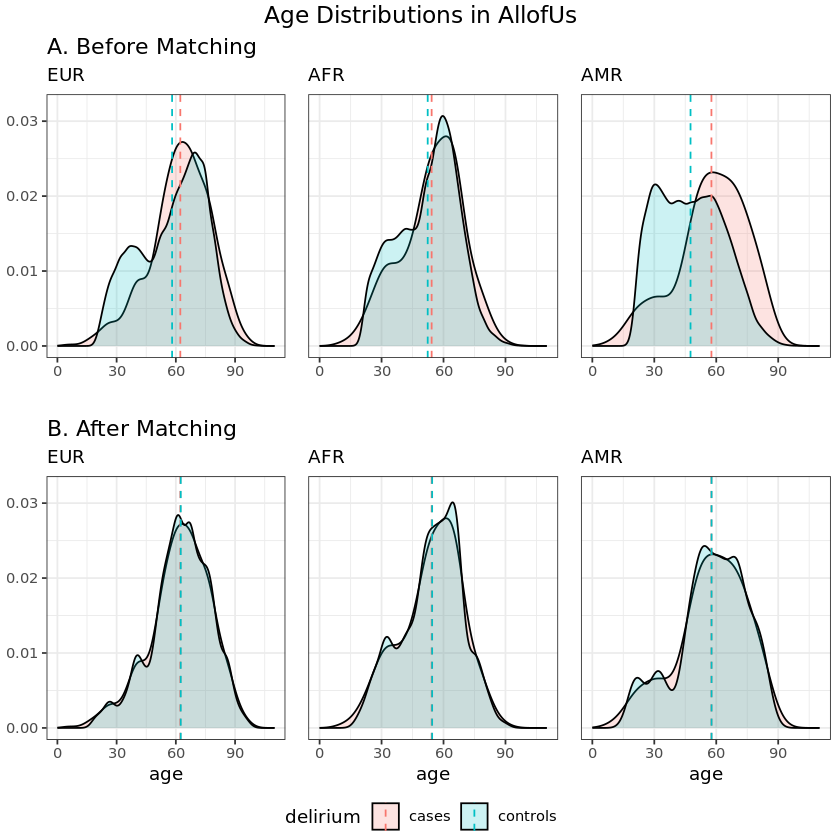

In [19]:
legend  <- get_legend(p31)
agedist <- 
ggarrange(p10, p20, p30, p11, p21, p31, 
          nrow = 2, ncol=3,
          common.legend = TRUE, legend="bottom", 
          widths=c(1.08,1,1),
          legend.grob = legend
          ) 

annotate_figure(agedist,
                top = text_grob("Age Distributions in AllofUs", size = 14, vjust =0.5))


ggsave("agedist1on10.png", dpi = 400)
ggsave("agedist1on10.pdf", dpi = 400)

**Save subsampled files:**

In [311]:
## 1:5 case/control mathcing 

# save to workspace
# write.table(eur_1on5[,1:15], "pheno/eur_pheno_clean_1on5.txt", sep=" ", row.names=F, col.names=T, quote=F)
# write.table(afr_1on5[,1:15], "pheno/afr_pheno_clean_1on5.txt", sep=" ", row.names=F, col.names=T, quote=F)
# write.table(amr_1on5[,1:15], "pheno/amr_pheno_clean_1on5.txt", sep=" ", row.names=F, col.names=T, quote=F)

# save to bucket
# system(paste0("gsutil cp ./", "pheno/eur_pheno_clean_1on5.txt", " ", my_bucket, "/data/pheno/clean/1on5/"), intern=T)
# system(paste0("gsutil cp ./", "pheno/afr_pheno_clean_1on5.txt", " ", my_bucket, "/data/pheno/clean/1on5/"), intern=T)
# system(paste0("gsutil cp ./", "pheno/amr_pheno_clean_1on5.txt", " ", my_bucket, "/data/pheno/clean/1on5/"), intern=T)



character(0)

character(0)

character(0)

In [20]:
## 1:10 case/control mathcing 

# save to workspace
write.table(eur_1on5[,1:15], "pheno/eur_pheno_clean_1on10.txt", sep=" ", row.names=F, col.names=T, quote=F)
write.table(afr_1on5[,1:15], "pheno/afr_pheno_clean_1on10.txt", sep=" ", row.names=F, col.names=T, quote=F)
write.table(amr_1on5[,1:15], "pheno/amr_pheno_clean_1on10.txt", sep=" ", row.names=F, col.names=T, quote=F)

# save to bucket
system(paste0("gsutil cp ./", "pheno/eur_pheno_clean_1on10.txt", " ", my_bucket, "/data/pheno/clean/1on10/"), intern=T)
system(paste0("gsutil cp ./", "pheno/afr_pheno_clean_1on10.txt", " ", my_bucket, "/data/pheno/clean/1on10/"), intern=T)
system(paste0("gsutil cp ./", "pheno/amr_pheno_clean_1on10.txt", " ", my_bucket, "/data/pheno/clean/1on10/"), intern=T)



character(0)

character(0)

character(0)

**Make _ids files (to use with --keep in plink2) for subsampled data:**

In [21]:
eur_ids <- eur_1on5 %>% select(FID,IID)
afr_ids <- afr_1on5 %>% select(FID,IID)
amr_ids <- amr_1on5 %>% select(FID,IID)
## save .txt to workspace
write.table(eur_ids, "eur_ids_clean_1on10.txt", sep=" ", row.names=F, col.names=F, quote=F)
write.table(afr_ids, "afr_ids_clean_1on10.txt", sep=" ", row.names=F, col.names=F, quote=F)
write.table(amr_ids, "amr_ids_clean_1on10.txt", sep=" ", row.names=F, col.names=F, quote=F)
## check
system("wc -l *_ids*.txt", intern=T)

## save .txt to bucket
system(paste0("gsutil cp ./", "*_ids_clean_1on10.txt", " ", my_bucket, "/data/pheno/clean/1on10/"), intern=T)

## check
system(paste0("gsutil ls ", my_bucket, "/data/pheno/clean/1on10/*"), intern=T)

[1] "  52536 afr_ids.txt"             "   2563 afr_ids_clean_1on10.txt"
 [3] "   1398 afr_ids_clean_1on5.txt"  "  40096 amr_ids.txt"            
 [5] "   1287 amr_ids_clean_1on10.txt" "    702 amr_ids_clean_1on5.txt" 
 [7] " 120476 eur_ids.txt"             "   7172 eur_ids_clean_1on10.txt"
 [9] "   3912 eur_ids_clean_1on5.txt"  " 230142 total"

character(0)

[1] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/1on10/afr_ids_clean_1on10.txt"  
[2] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/1on10/afr_pheno_clean_1on10.txt"
[3] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/1on10/amr_ids_clean_1on10.txt"  
[4] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/1on10/amr_pheno_clean_1on10.txt"
[5] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/1on10/eur_ids_clean_1on10.txt"  
[6] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/clean/1on10/eur_pheno_clean_1on10.txt"